# M2NIST with Fast.AI

In [30]:
! export CUDA_LAUNCH_BLOCKING=1
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Goals and context

We are going to use the [Multidigit MNIST(M2NIST)](https://www.kaggle.com/farhanhubble/multimnistm2nist) dataset. It's a segmentation dataset, containing picture of two MNIST number put together, and the appropriate labels. 
We will use Fast.ai as this notebook is done as a homework the 3rd lesson of the course.

## Data exploration
First we will explore the data a bit and try to present it in a convenient way:

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from fastai.vision import *

In [32]:
path = 'data/multimnist'
combined = np.load(path + '/combined.npy')
segmented = np.load(path + '/segmented.npy')

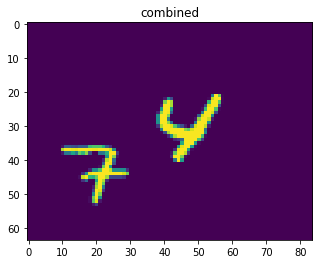

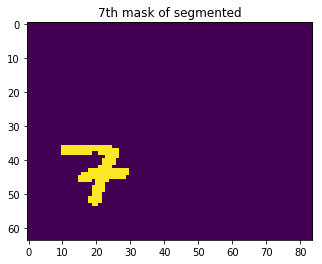

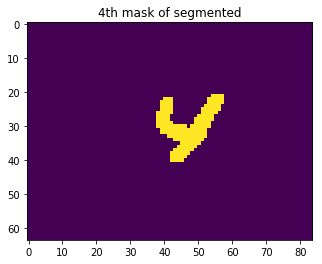

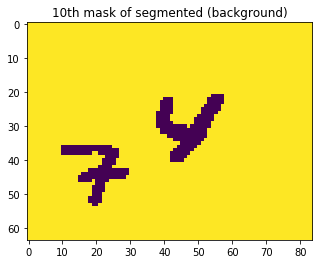

In [33]:
plt.imshow(combined[1])
plt.title("combined")
plt.show()
plt.imshow(segmented[1,:,:,7])
plt.title("7th mask of segmented")
plt.show()
plt.imshow(segmented[1,:,:,4])
plt.title("4th mask of segmented")
plt.show()
plt.imshow(segmented[1,:,:,10])
plt.title("10th mask of segmented (background)")
plt.show()

Would be a good idea to tranform those mask into a single array containing the number where it appears, and a 10 otherwise. It would be closer to a real image and so easier to work with in fastai.

In [34]:
n_sample = len(segmented)
height = len(segmented[0])
width = len(segmented[0][0])

segmented_flat = np.zeros((n_sample, height, width))
for idx in range(n_sample):
    print(f'{idx}/{n_sample - 1}', end="\r")
    for j in range(height):
        for i in range(width):
            for n in range(11):
                if segmented[idx][j][i][n]: 
                    segmented_flat[idx][j][i] = n
np.save(path + '/segmented_flat.npy', segmented_flat)

In [35]:
! mkdir data/multimnist/label
! mkdir data/multimnist/input

segmented_flat = np.load(path + '/segmented_flat.npy')
for idx in range(n_sample):
    print(f'Segmented: {idx}/{n_sample - 1}', end="\r")
    # We have to be carefulwith the cmap and the range of the value since we went value to correspond to our codes
    plt.imsave(path + f'/label/{idx}.png', segmented_flat[idx,:,:], cmap='gray', vmin=0, vmax=255) 

print("\n")
for idx in range(n_sample):
    print(f'Input: {idx}/{n_sample - 1}', end="\r")
    plt.imsave(path + f'/input/{idx}.png', combined[idx,:,:], cmap='gray')
del segmented_flat

mkdir: cannot create directory ‘data/multimnist/label’: File exists
mkdir: cannot create directory ‘data/multimnist/input’: File exists
Segmented: 4999/4999



## Using the DataBlock API

(array([64, 84]), tensor([[[10, 10, 10,  ..., 10, 10, 10],
          [10, 10, 10,  ..., 10, 10, 10],
          [10, 10, 10,  ..., 10, 10, 10],
          ...,
          [10, 10, 10,  ..., 10, 10, 10],
          [10, 10, 10,  ..., 10, 10, 10],
          [10, 10, 10,  ..., 10, 10, 10]]]))

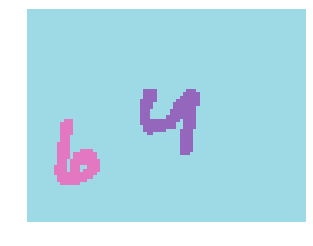

In [36]:
np.random.seed(42)
SPLIT = 0.2
BS = 2

get_y_fn = lambda x: path + f'/label/{x.stem}{x.suffix}'
codes = array(['0','1','2','3','4','5','6','7','8','9','Background'])

fnames = get_image_files(path +'/input')
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(5,5), alpha=1)
src_size = np.array(mask.shape[1:])
src_size,mask.data

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Background'], dtype='<U10')

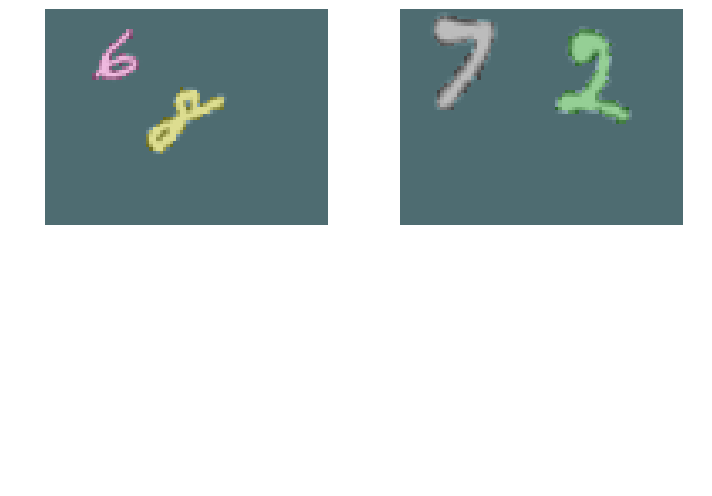

In [37]:
data = (SegmentationItemList.from_folder(path + '/input')
       .split_by_rand_pct(valid_pct=SPLIT)
       .label_from_func(get_y_fn, classes=codes)
       .transform(get_transforms(do_flip=False), tfm_y=True) # We do not want writing to be flipped, that makes no sense
       .databunch(bs=BS)
       .normalize(imagenet_stats))

data.show_batch(4, figsize=(10,7))
data.classes

 # Model

In [38]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target): # No need to reinvent the wheel !
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()



In [39]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


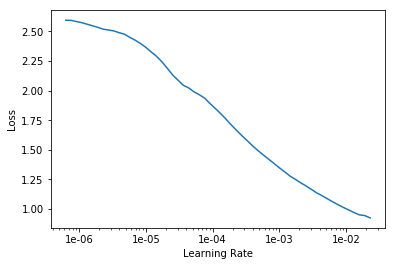

In [40]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.116477,0.127004,0.398638,01:42
1,0.067645,0.053669,0.707312,01:41
2,0.052887,0.040231,0.775369,01:42
3,0.039520,0.031091,0.842259,01:42
4,0.038467,0.023763,0.880432,01:42
5,0.032851,0.019195,0.906188,01:42
6,0.035349,0.026682,0.857801,01:42
7,0.031160,0.019149,0.915122,01:42
8,0.033643,0.015880,0.924311,01:42
9,0.021873,0.014292,0.926266,01:42


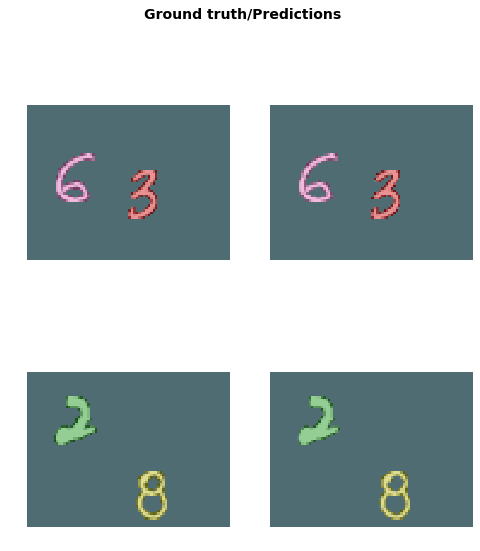

In [41]:
lr = 1e-04
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
learn.save('M2NIST-stage-1')
learn.show_results(rows=3, figsize=(8,9))

## Fine-Tuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


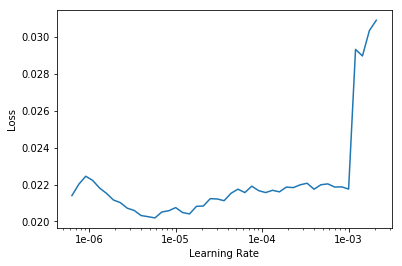

In [43]:
lr_find(learn)
learn.recorder.plot()

In [44]:
learn.load('M2NIST-stage-1')
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-06,  4e-06), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.023132,0.014258,0.928342,02:22
1,0.021237,0.013991,0.927598,02:22


In [45]:
learn.save('M2NIST-stage-2')

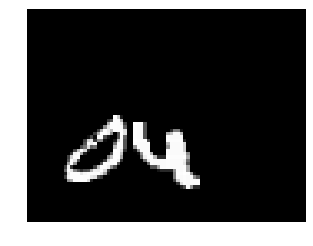

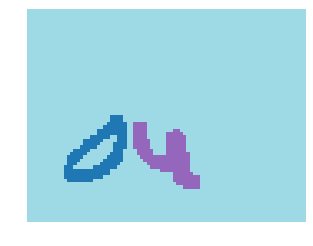

In [47]:
img = open_image(fnames[42])
img.show(figsize=(5,5), alpha=1)
predicted_mask = learn.predict(img)[0]
predicted_mask.show(figsize=(5,5), alpha=1)